# matchtesting算出matrix

In [52]:
import cv2, numpy as np
import json,math,os
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

## 输入

In [53]:
#imagespath="../data/2403261/captured/position_00a/"
imagespath="./data/240415/captured/position_00a/"
phcopath="./data/phco.txt"
arucopath='./data/aruco2.png'
match_nppath="./result/match.npy"
projector_id=0
pro_size = (640, 480) # Projector image plane size
cam_size = (1280, 720) # Camera image plane size

In [54]:
import os

def load_images_from_folder(folder):
    images = []
    for filename in sorted(os.listdir(folder)):

        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)

        if img is not None:
            images.append(img)
    return images
captured_gray_images = load_images_from_folder(imagespath)
# Load captured Gray code image for decoding


## Gray解码

#### log2*2 

In [55]:
def computeNumberOfPatternImages(width, height):
    assert width > 0 and height > 0
    n_cols = int(np.ceil(np.log2(width))) * 2 #ceil向上取整 宽度 log2
    n_rows = int(np.ceil(np.log2(height))) * 2
    return n_cols, n_rows

#### 将一个格雷码Gray编码的数字解码为其对应的十进制数。

In [56]:
def gray_decoder(gray):
    dec = 0
    tmp = gray[0]
    if tmp:
        dec += 2 ** (len(gray) - 1)
    for i in range(1, len(gray)):
        tmp = tmp ^ gray[i]
        if tmp:
            dec += 2 ** (len(gray) - i - 1)
    return dec

### 1. Gray过滤出匹配点并记录


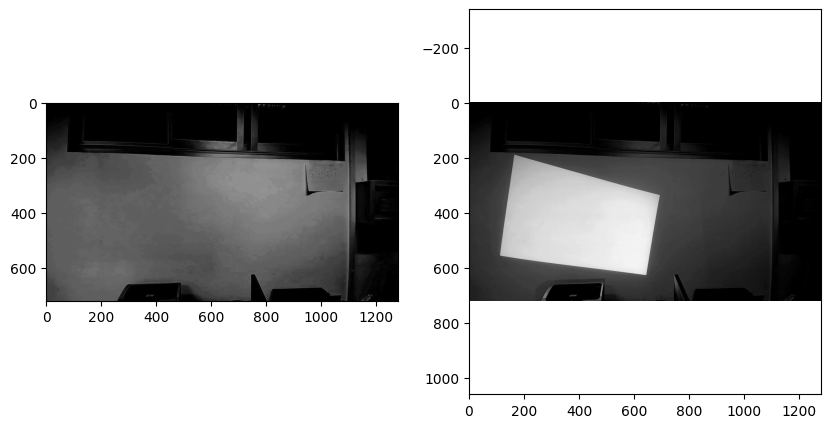

In [57]:
n_cols, n_rows = computeNumberOfPatternImages(pro_size[0], pro_size[1])
#根据投影图像的尺寸log2再*2，计算出需要多少张格雷码图像来完全编码这个空间
n_patterns = n_cols + n_rows#1920*1080下22+22=44  张图片
black_img, white_img = captured_gray_images[n_patterns:n_patterns + 2]
#生成阴影掩码: 使用一对黑白图像 格雷码序列的最后两张图像来生成一个阴影掩码，这个掩码用于标识图像中有效的区域和被阴影遮挡的区域。
def check2gray(i1,i2):
    # 画两个gray图
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(i1, cmap='gray')
    axes[1].imshow(i2, cmap='gray')
    plt.axis('equal')
    # 显示图形
    plt.show()
check2gray(black_img,white_img)

#### 用全白-全黑剩余 

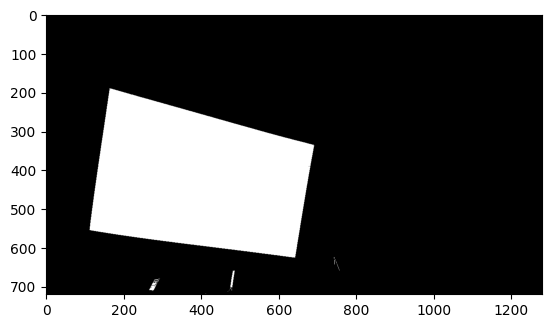

In [58]:
shadow_thresh=50 #调的越小越亮
shadow_mask = white_img.astype(np.int32) - black_img.astype(np.int32)
shadow_mask = np.greater(shadow_mask, shadow_thresh)#shadow_thresh
shadow_mask = shadow_mask.astype(np.uint8) * 255
plt.imshow(shadow_mask, cmap='gray')


In [59]:
# import ipywidgets as widgets
# from IPython.display import display
# code_mask = white_img.astype(np.int32) + black_img.astype(np.int32) / 2
# # 获取图像中心点坐标和像素值
# center_x = code_mask.shape[1] // 2
# center_y = code_mask.shape[0] // 2
# center_value = code_mask[center_y, center_x]
# # 创建图像显示
# img = widgets.Image(value=code_mask, format="png")
# # 创建文本显示灰度值
# text = widgets.Text(value="")


# def on_click(change):
#     if change["new"]:
#         x = change["owner"].x
#         y = change["owner"].y
#         gray_value = code_mask[y, x]
#         text.value = f"灰度值:{gray_value}"

# img.observe(on_click, "selected_x")
# img.observe(on_click, "selected_y")

# # 展示组件

# display(img, text)




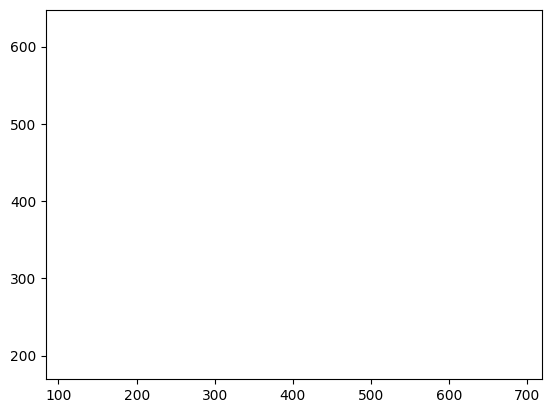

In [60]:

# 找出shadow_mask上的最大四边形
contours, _ = cv2.findContours(shadow_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
max_area = 0
max_contour = None
for contour in contours:
    area = cv2.contourArea(contour)
    if area > max_area:
        max_area = area
        max_contour = contour
if max_contour is not None:
    epsilon = 0.02 * cv2.arcLength(max_contour, True)
    approx = cv2.approxPolyDP(max_contour, epsilon, True)
    plt.fill(approx[:, 0, 0], approx[:, 0, 1], color=(1, 1, 1))


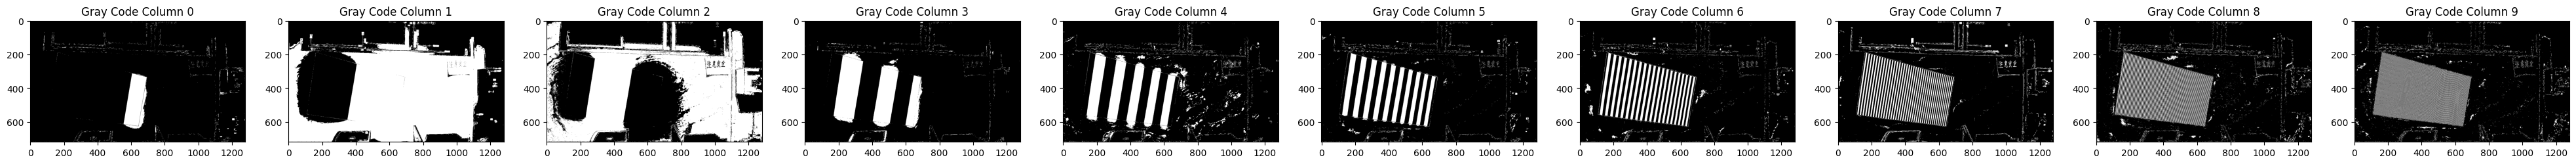

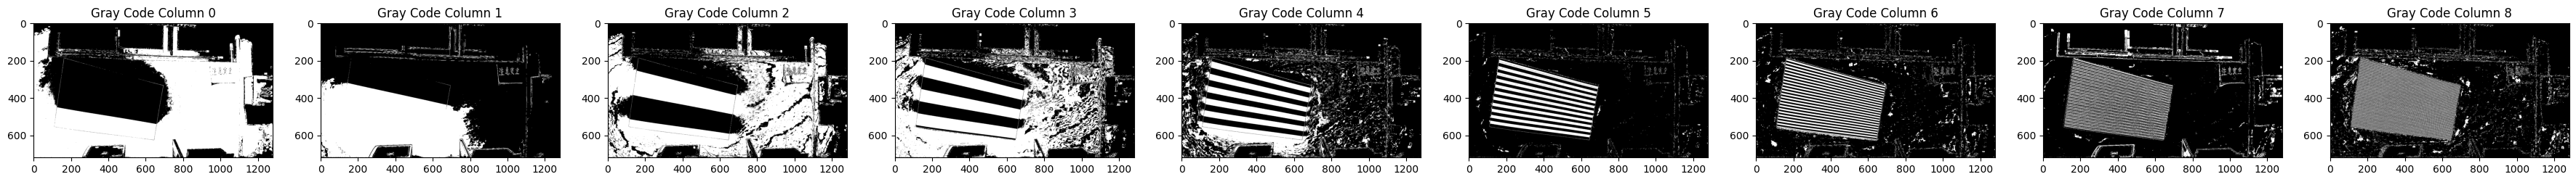

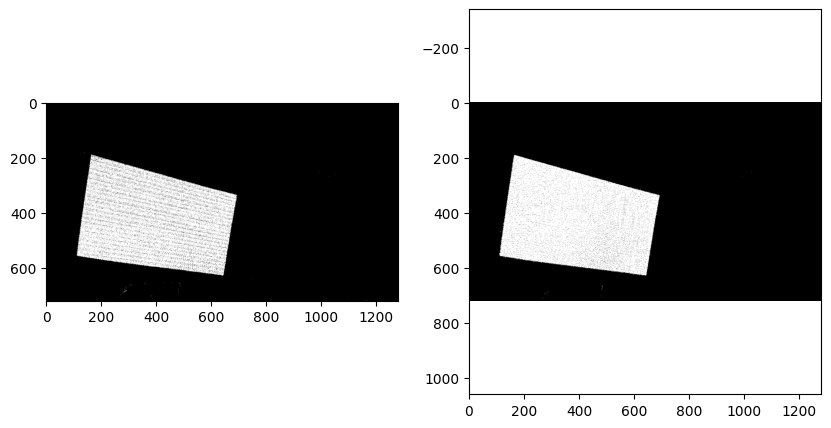

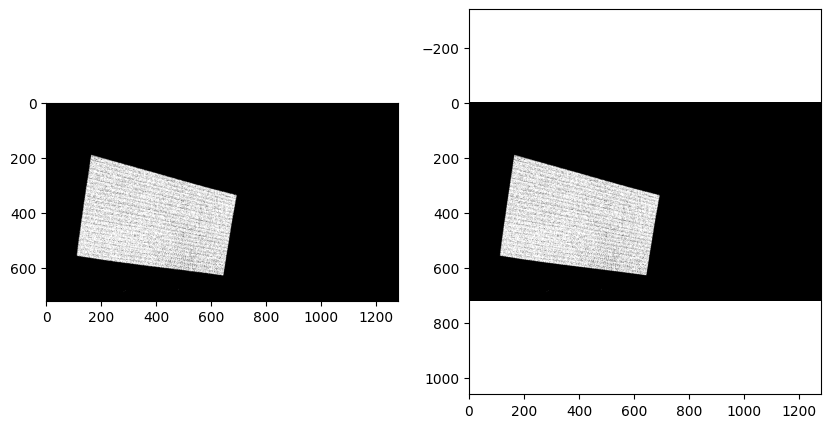

In [61]:
code_thresh=2#减小之后点会增多
gray_col_stack = np.stack(captured_gray_images[0:n_cols:2]).astype(np.int32) - np.stack(captured_gray_images[1:n_cols:2]).astype(np.int32)
gray_col = np.greater(gray_col_stack, 0)
dec_mask_col = np.greater(np.abs(gray_col_stack), code_thresh)
dec_mask_col = np.logical_and.reduce(dec_mask_col, axis=0)
gray_row_stack = np.stack(captured_gray_images[n_cols:n_cols+n_rows:2]).astype(np.int32) - np.stack(captured_gray_images[n_cols+1:n_cols+n_rows:2]).astype(np.int32)
gray_row = np.greater(gray_row_stack, 0)
dec_mask_row = np.greater(np.abs(gray_row_stack), code_thresh)
dec_mask_row = np.logical_and.reduce(dec_mask_row, axis=0)

# 创建一个大图，其中包含所有gray_col[index]的子图
def checkcol(rcol):
    n_subplots = rcol.shape[0]
    fig, axes = plt.subplots(1, n_subplots, figsize=(n_subplots * 5, 5))
    for i in range(n_subplots):
        axes[i].imshow(rcol[i], cmap='gray')
        axes[i].set_title(f'Gray Code Column {i}')
    plt.show()
checkcol(gray_col);
checkcol(gray_row);
dec_mask = np.logical_and(dec_mask_col, dec_mask_row)
mask = np.logical_and(dec_mask, shadow_mask)
check2gray(dec_mask_row,dec_mask_col)
check2gray(dec_mask,mask)

### 2.生成投影机Gray到相机捕获图像点cmr_match_pjt字典

In [62]:
def cmrmatchpjt(mask):
    cmr_match_pjt = {}
    for i in range(mask.shape[1]):
        for j in range(mask.shape[0]):
            if mask[j, i]:
                xDec = gray_decoder(gray_col[:, j, i])
                yDec = gray_decoder(gray_row[:, j, i])
                if xDec < pro_size[0] and yDec < pro_size[1]:
                    prj_idx = (projector_id, xDec, yDec)
                    # Projector number and matched coordinates
                    if prj_idx not in cmr_match_pjt:
                        cmr_match_pjt[prj_idx] = []
                    cmr_match_pjt[prj_idx].append((i, j))
    #cmr_match_pjt: 一个字典，键是由投影仪编号和解码后的投影仪图像平面坐标组成的元组，如(0, 1726, 427)
    # 值是一个列表，包含了对应于这些投影仪坐标的相机图像平面上的点的坐标
    # 如  546,   216
    test_dict =  {str(key): value for key, value in cmr_match_pjt.items()}
    # 将字典转换为JSON格式的字符串，并保存到文件
    #cmrdictdir='./result/data.txt'
    # with open(cmrdictdir, 'w', encoding='utf-8') as f:
    #     json.dump(test_dict, f, indent=4, ensure_ascii=False)
    return cmr_match_pjt

cam_match_pro=cmrmatchpjt(mask)



## 建立投影机图像平面坐标与投影图像像素坐标的匹配
#map_x, map_y = relation(anchors, cmr_match_pjt, ph_coordinate, pro_size, cam_size)
#Establishing a match between projector image plane coordinates and projected image pixel coordinates

### 4.在投影仪的图像平面和cam图像平面之间建立一一对应的关系。
输入cmr_match_pjt通过插值方法实现这一点，并返回一个包含映射信息的矩阵。


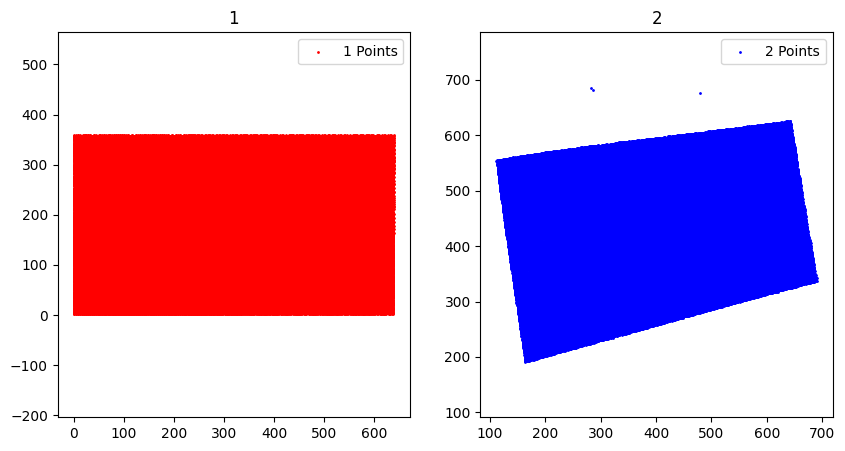

In [63]:
# The matching of each point in the image plane of the projector and the camera is accomplished using interpolation, and unmatched points are recorded as Nan
pro_know = [] # The coordinates of the projection plane
cam_know = [] # The coordinates of the camera plane
for i in cam_match_pro:
    pro_know.append(i[1:])#i[1:]，代码获取了元组中的后两个元素（x和y坐标）
    cam_know.append(cam_match_pro[i][0])
# - 首先，函数遍历 cmr_match_pjt 中的每个条目，将投影仪平面的坐标和相机平面的坐标分别存储在 `pro_know` 和 `cam_know` 列表中。
pro_know = np.array(pro_know)
cam_know = np.array(np.array(cam_know).reshape(-1,2))#reshape(-1, 2)中的-1表示根据数组的大小自动确定该维度

def check2scatter(pro_know,cam_know):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('1')
    plt.scatter(pro_know[:, 0], pro_know[:, 1], s=1,c='red', label='1 Points')
    plt.legend()
    plt.axis('equal')
    plt.subplot(1, 2, 2)
    plt.title('2')
    plt.scatter(cam_know[:, 0], cam_know[:, 1], s=1,c='blue', label='2 Points')
    plt.axis('equal')
    plt.legend()
    plt.show()
def check2ttt(map_x,map_y):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('1')
    plt.imshow(map_x)
    plt.legend()
    plt.axis('equal')
    plt.subplot(1, 2, 2)
    plt.title('2')
    plt.imshow(map_x) 
    plt.axis('equal')
    plt.legend()
    plt.show()
check2scatter(pro_know,cam_know)

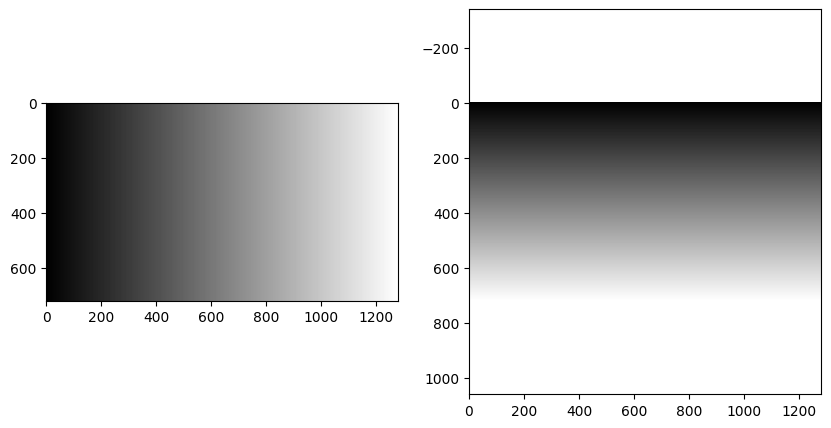

In [64]:
# Interpolation to achieve a one-to-one correspondence between the projection plane and the camera plane results are stored in cam_pro
# (how the points in pro are filled into cam)
#插值实现投影平面和相机平面的一对一对应结果存储在cam_pro中
grid_x = np.linspace(0, cam_size[0]-1, cam_size[0])  # x coordinate range
grid_y = np.linspace(0, cam_size[1]-1, cam_size[1])  # y coordinate range

grid_x, grid_y = np.meshgrid(grid_x, grid_y)
check2gray(grid_x,grid_y)


In [65]:

points_to_remap = np.column_stack((grid_x.flatten(), grid_y.flatten()))
#是否 适配camknow   480p到1080p
#check2scatter(pro_know,points_to_remap)
print(points_to_remap)
print(cam_know.shape)
print(pro_know.shape)
print(points_to_remap.shape)

[[0.000e+00 0.000e+00]
 [1.000e+00 0.000e+00]
 [2.000e+00 0.000e+00]
 ...
 [1.277e+03 7.190e+02]
 [1.278e+03 7.190e+02]
 [1.279e+03 7.190e+02]]
(90982, 2)
(90982, 2)
(921600, 2)


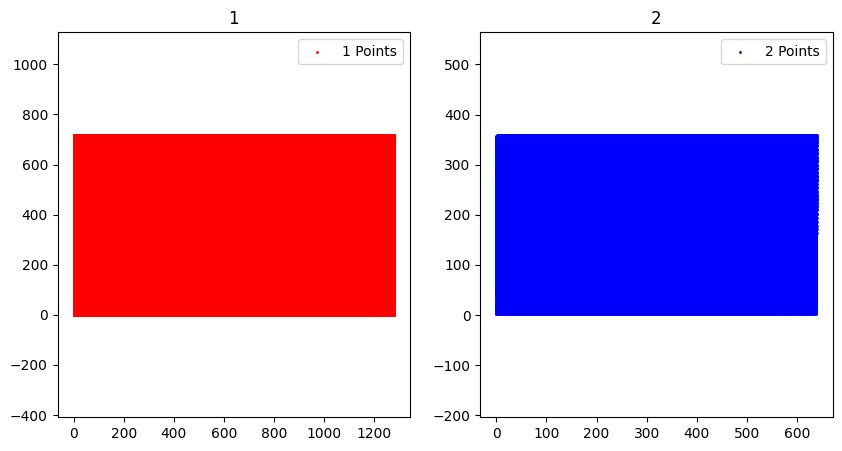

(921600, 2)


In [66]:
#函数将 cam_know 中的点映射到 pro_know 中的点，通过插值方法填充整个相机图像平面，得到 cam_pro。
cam_pro = griddata(cam_know, pro_know, points_to_remap, method='linear')
# The 'method' parameter in the griddata function specifies the interpolation method to use. Some common methods include:
# - 'linear': Linear interpolation
# - 'nearest': Nearest-neighbor interpolation
# - 'cubic': Cubic interpolation
# - 'quintic': Quintic interpolation
# - 'linearND': Linear interpolation in N dimensions
# - 'cubicND': Cubic interpolation in N dimensions
check2scatter(points_to_remap,cam_pro)
print(cam_pro.shape)


In [67]:
map_x = np.zeros([cam_size[1], cam_size[0]], dtype=float)
map_y = np.zeros([cam_size[1], cam_size[0]], dtype=float)
print(map_x)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


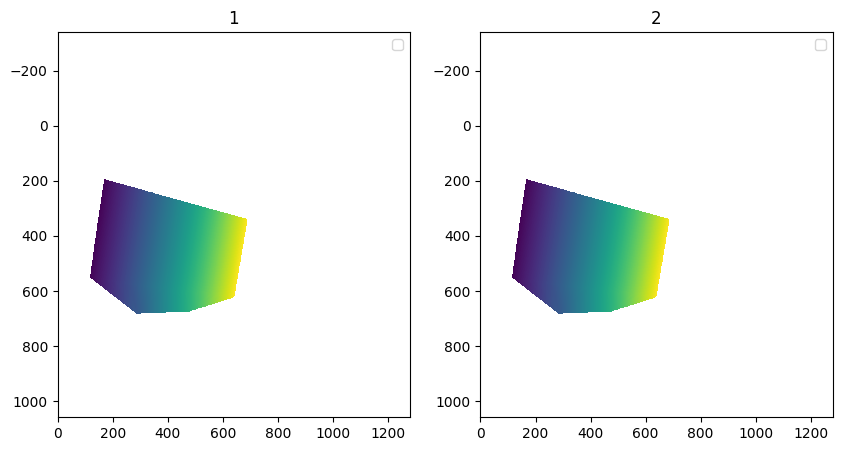

(2, 720, 1280)


array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])

In [68]:
for idx, num in enumerate(cam_pro):
    map_x[idx // cam_size[0]][idx % cam_size[0]] = num[0]
    map_y[idx // cam_size[0]][idx % cam_size[0]] = num[1]
#这段代码片段基于索引将插值点从cam_pro映射到map_x和map_y矩阵。
#它将每个点的x坐标分配给map_x, y坐标分配给map_y
check2ttt(map_x,map_y)
map_x, map_y = map_x.reshape(-1, map_x.shape[0], map_x.shape[1]), map_y.reshape(-1, map_x.shape[0], map_x.shape[1])
#将二维数组 map_x 调整形状为三维
martix = np.concatenate((map_x, map_y), axis=0)
print(martix.shape)
martix

## Aruco建立真实世界坐标与相机坐标和像素坐标

In [69]:
Aruco_img = cv2.imread(arucopath)

### 生成字典dict1,转置没啥用

In [70]:
#读取一张特定的图像并使用 Aruco_detect 函数检测其中的Aruco标记，得到 anchors。
# Aruco code position detection in the camera image plane
def dict1():
    aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
    myByteList = []
    for idx, code in enumerate(aruco_dict.bytesList):
        #遍历现有Aruco字典（aruco_dict.bytesList）中的每个编码（code）
        code = code[np.newaxis, :, :]
        # 将当前的code通过np.newaxis增加一个维度，以适配cv2.aruco.Dictionary_getBitsFromByteList函数的输入要求。
        bits = cv2.aruco.Dictionary_getBitsFromByteList(code, 4)
        #cv2.aruco.Dictionary_getBitsFromByteList函数将字节列表转换为位矩阵（bits）。
        bits = cv2.flip(bits, 1)
        #使用cv2.flip函数沿着水平方向（参数为1）翻转位矩阵，这可能是为了满足特定的标记识别要求或纠正方向。
        code = cv2.aruco.Dictionary_getByteListFromBits(bits)
        # 将翻转后的位矩阵(bits)重新转换为字节列表(code)，以便后续使用。
        myByteList.append(code[0])
        #将转换后的字节列表添加到myByteList中。
    myByteList = np.stack(myByteList, axis=0)
    return myByteList
dict1 = cv2.aruco.Dictionary(dict1(), 4)


### 3.检测Aruco码
得到anchors

corners : 15


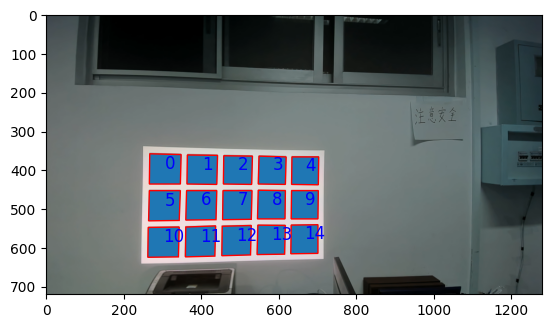

C:\Users\robert\AppData\Local\Temp\ipykernel_16388\967704299.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx = int(idx)


In [71]:
def Aruco_detect1(Aruco_img,dict1):
    anchors = {}
    corners, ids, _ = cv2.aruco.detectMarkers(Aruco_img, dict1, parameters=cv2.aruco.DetectorParameters())
    print('corners :',len(corners))
    if len(corners) == 0:
        print("Please retest")
        raise AssertionError

    if ids is not None:
        corners = np.array(corners).reshape(-1, 4, 2)
        center_points = np.mean(corners, 1)
    checkacruco(corners)
    for i, idx in enumerate(ids):
        idx = int(idx)
        anchors[idx] = center_points[i]
    return anchors
def checkacruco(corners):
    fig, ax = plt.subplots()
    for corner in corners:
        points = corner.reshape(-1, 2)
        polygon = plt.Polygon(points, edgecolor='r')
        ax.add_patch(polygon)
    for anchor_id, center_point in anchors.items():
        plt.text(center_point[0], center_point[1], str(anchor_id), color='blue', fontsize=12)
    plt.imshow(Aruco_img, cmap='gray')
    plt.show()
anchors=Aruco_detect1(Aruco_img, dict1) 

# 投影机图像平面与real图像中校准点的匹配



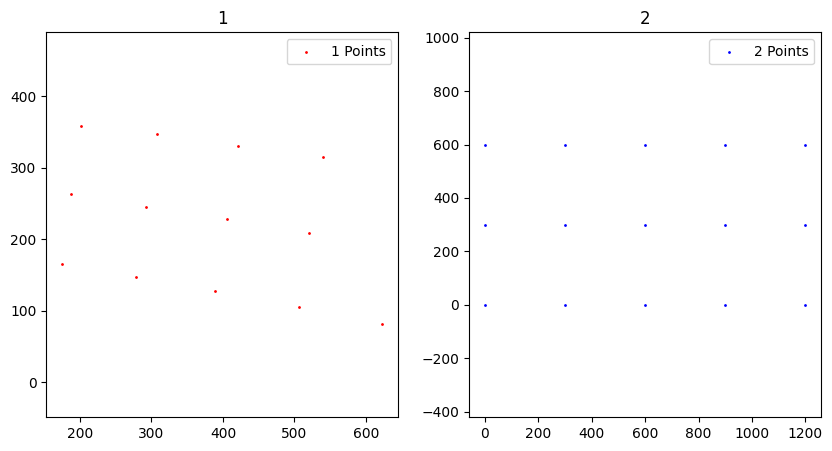

In [72]:
def pro_real_match(martix, anchors, phcopath):
    # Matching of projector image plane and projected image

    # Matching of the projector image plane and the calibrated points in the projected image
    cam_know = [] # The position of the Aruco code in the image plane of the camera
    idx_Aruco = [] # Aruco code number
    for key, value in anchors.items():
        cam_know.append(np.array([int(value[1]), int(value[0])]))
        idx_Aruco.append(key)
    cam_know = np.array(cam_know)
    # Matching of projector image plane and projected image
    pro_real = {} # The coordinates of the points corresponding to the pixel points in the projector.
    for n, m in enumerate(cam_know):
        pro_real[idx_Aruco[n]] = np.array([(martix[0][m[0]][m[1]]), (martix[1][m[0]][m[1]])])
    # Reading calibrated projected image coordinates
    real_dic = {} # Aruco code in the coordinates of the projected image and its corresponding id
    #Aruco代码中投影图像的坐标及其对应的id
    real_np = np.loadtxt(phcopath, encoding='utf-8', dtype=float)
    for i in real_np:
        real_dic[i[0]] = [i[1], i[2]]
    pro = [] # Pixel coordinates of points in the projector that match the projected image
    real = [] # Pixel coordinates of points where the projected image matches the projector
    #real图像与投影仪相匹配的点的像素坐标
    # 记录投影平面和投影图像的匹配关系
    for key, value in pro_real.items():
        pro.append(value)
        real.append(real_dic[key])
    pro = np.array(pro)
    real = np.array(real)
    check2scatter(pro, real)
    return pro,real
pro,real=pro_real_match(martix, anchors, phcopath)

### 预测投影机图像平面与投影图像中校准点匹配失败之间的匹配



In [73]:

# Predicting the match between the projector image plane and the failure of the calibration points to match in the projected image
def predict_unknow(pro, real):
    pro_unknow = [] # Unknown point in projected coordinates
    real_unknow = [] # pro_unknow corresponds to the points in the projected image
    pro_know = [] # Projected coordinates of known points
    real_know = [] # pro_know corresponds to the point of the projected image
    for idx, num in enumerate(pro):
        if(math.isnan(num[0])):
            pro_unknow.append(num)
            real_unknow.append(real[idx])
        else:
            pro_know.append(num)
            real_know.append(real[idx])
    # Predicting the value of an unknown point by transformation
    if (len(real_unknow)!=0):
        pro_unknow = np.array(pro_unknow)
        real_unknow = np.array(real_unknow)
        pro_know = np.array(pro_know)
        real_know = np.array(real_know)
        print(real_know)
        print('the shape of real_know:',real_know.shape)
        print('the shape of pro_know:',pro_know.shape)
        M, _ = cv2.findHomography(real_know, pro_know) # transformation matrix
        pro_new = cv2.perspectiveTransform(real_unknow.reshape(-1, 1, 2), M).reshape(-1,2) # Predicted results
        # Record of the matching relationship between the calibration point (real_all) and the projector image plane (pro_all) point in projected images
        pro_all = np.vstack((pro_know,pro_new))
        real_all =  np.vstack((real_know,real_unknow))
    else:
        pro_all = np.array(pro_know)
        real_all =  np.array(real_know)
    return pro_all, real_all
pro_all, real_all = predict_unknow(pro, real)

[[1199.    0.]
 [   0.  599.]
 [ 299.  599.]
 [ 599.  599.]
 [ 899.  599.]
 [ 299.  299.]
 [   0.  299.]
 [ 899.  299.]
 [ 599.  299.]
 [ 899.    0.]
 [ 599.    0.]
 [   0.    0.]
 [ 299.    0.]]
the shape of real_know: (13, 2)
the shape of pro_know: (13, 2)


In [74]:

# One-to-one matching of projector image plane coordinates and projected image pixel coordinates
def get_martix(pro_all, real_all, pro_size):
    # Determine how points in the image plane of the projector are projected into the projected image by interpolation
    grid_x = np.linspace(0, pro_size[0]-1, pro_size[0])
    grid_y = np.linspace(0, pro_size[1]-1, pro_size[1])
    grid_x, grid_y = np.meshgrid(grid_x, grid_y)
    points_to_remap = np.column_stack((grid_x.flatten(), grid_y.flatten()))
    remapped_points = griddata(pro_all,real_all, points_to_remap, method='cubic')
    mapx = np.zeros([pro_size[1], pro_size[0]], dtype=float)
    mapy = np.zeros([pro_size[1], pro_size[0]], dtype=float)
    for idx, num in enumerate(remapped_points):
        mapx[idx // pro_size[0]][idx % pro_size[0]] = num[0]
        mapy[idx // pro_size[0]][idx % pro_size[0]] = num[1]
    mapx = np.float32(mapx)
    mapy = np.float32(mapy)
    return mapx, mapy


In [75]:

map_x, map_y = get_martix(pro_all, real_all, pro_size)

#传入Aruco标记的 anchors、解码得到的匹配信息 cmr_match_pjt、投影图像坐标 ph_coordinate、投影仪尺寸 pro_size 和相机尺寸 cam_size，计算出映射关系，得到 map_x 和 map_y
map_x, map_y = map_x.reshape(1, -1, map_x.shape[0], map_x.shape[1]), map_y.reshape(1, -1, map_x.shape[0], map_x.shape[1])
martrix = np.concatenate((map_x, map_y), axis=1)
np.save(match_nppath, martrix)

# Render

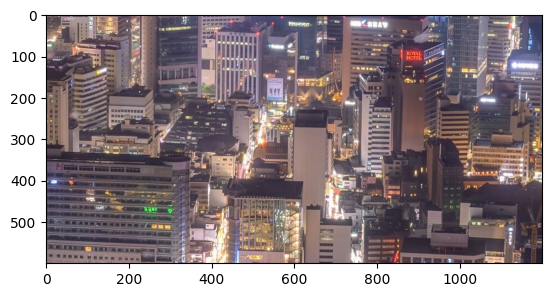

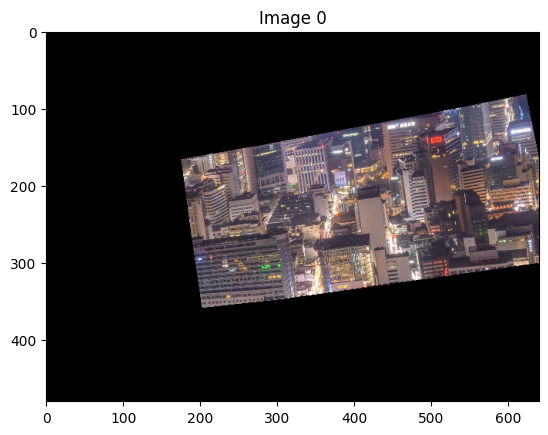

(2, 480, 640)


In [76]:
image = cv2.imread("./pic.png",)
map_matrixs = np.load(match_nppath)
# Corrects the projected image according to the matching result
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()
for idx,map_martix in enumerate(map_matrixs):
    part = cv2.remap(image, map_martix[0], map_martix[1], interpolation=cv2.INTER_LINEAR)
    plt.imshow(cv2.cvtColor(part, cv2.COLOR_BGR2RGB))
    plt.title(f'Image {idx}')
    plt.show()
print(map_martix.shape)

In [77]:
martrix.shape

(1, 2, 480, 640)